In [17]:
%reload_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.append("..")

import os
import argparse
import json

import torch
from torchvision.transforms import Normalize
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

from src.models.base_unet import BaseUNet
from src.models.unet_pp import UNetPlus
from src.utils.visualizations import plot_predictions
from src.utils.io import load_image, save_mask
from src.scripts.mask_to_submission import masks_to_submission

In [19]:
models = os.listdir("../logs")

scores = []
for dir in models:
    metrics = json.load(open(f"../logs/{dir}/metrics.json", "r"))
    scores.append((dir, max(metrics['val_acc'])))

threshold = 0.92
count = np.sum([1 for score in scores if score[1] > threshold])
print(f"Number of models with score > {threshold}: {count}")
print()

scores.sort(key=lambda x: x[1], reverse=True)
for score in scores:
    print(score)


Number of models with score > 0.92: 14

('2023-07-19_01-39-33', 0.9300405234098434)
('2023-07-19_01-00-06', 0.9284140765666962)
('2023-07-18_18-05-55', 0.9262954443693161)
('2023-07-19_05-13-07', 0.9261408001184464)
('2023-07-19_09-20-50', 0.9247572869062424)
('2023-07-18_17-26-08', 0.9245528727769852)
('2023-07-18_21-13-39', 0.9241626709699631)
('2023-07-19_05-52-19', 0.9238899946212769)
('2023-07-18_19-20-09', 0.9234243035316467)
('2023-07-19_02-58-01', 0.9233724772930145)
('2023-07-18_20-39-08', 0.9218239337205887)
('2023-07-19_00-20-46', 0.9216332584619522)
('2023-07-19_08-13-17', 0.9212025552988052)
('2023-07-19_04-05-31', 0.9207967072725296)
('2023-07-19_06-31-25', 0.917599231004715)
('2023-07-19_07-05-12', 0.9140616357326508)
('2023-07-18_23-06-54', 0.9139110594987869)
('2023-07-19_07-39-07', 0.913862556219101)
('2023-07-19_02-18-42', 0.9117555618286133)
('2023-07-19_04-39-23', 0.9104836285114288)
('2023-07-19_03-31-44', 0.9100898504257202)
('2023-07-19_08-46-59', 0.909880831837

In [20]:
N = 1

checkpoints = [f"../logs/{score[0]}" for score in scores[:N]]

In [21]:
metadata = "../metadata.json"

metadata = json.load(open(metadata, "r"))

In [22]:
def load_model(checkpoint):
    with open(os.path.join(checkpoint, "config.json"), "r") as f:
        vars = json.load(f)
    args = argparse.Namespace(**vars)

    chs = [3] + [2 ** (i + 5) for i in range(args.depth)]
    if args.model == "unet":
        model = BaseUNet(chs)
    elif args.model == "unet++":
        model = UNetPlus(chs)
    else:
        raise ValueError("Invalid model name")
    
    model.load_state_dict(torch.load(os.path.join(checkpoint, "best_model.pt"), map_location=torch.device("cpu")))

    return model, args

# Get test images

In [23]:
test_images = "../data/test/images/"

fnames = os.listdir(test_images)
fnames = [os.path.join(test_images, fname) for fname in fnames if fname.endswith(".png")]

len(fnames)

144

# Predict test images

In [24]:
def predict_mask(path, checkpoints):
    mean = metadata["cil"]["img_mean"]
    std = metadata["cil"]["img_std"]

    transform = Normalize(mean=mean, std=std)

    image = load_image(path)
    image = torch.tensor(image)
    image = image.permute(2, 0, 1).unsqueeze(0).float()
    image = transform(image)

    preds = []
    for ckpt in checkpoints:
        model, args = load_model(ckpt)

        model.eval()
        model.to("mps")
        with torch.no_grad():
            prediction = model(image.to("mps")).squeeze(0)
            preds.append(prediction.cpu())

    return torch.stack(preds).mean(0)

predictions = torch.stack([predict_mask(fname, checkpoints) for fname in tqdm(fnames)])
predictions.shape

100%|██████████| 144/144 [00:16<00:00,  8.70it/s]


torch.Size([144, 400, 400])

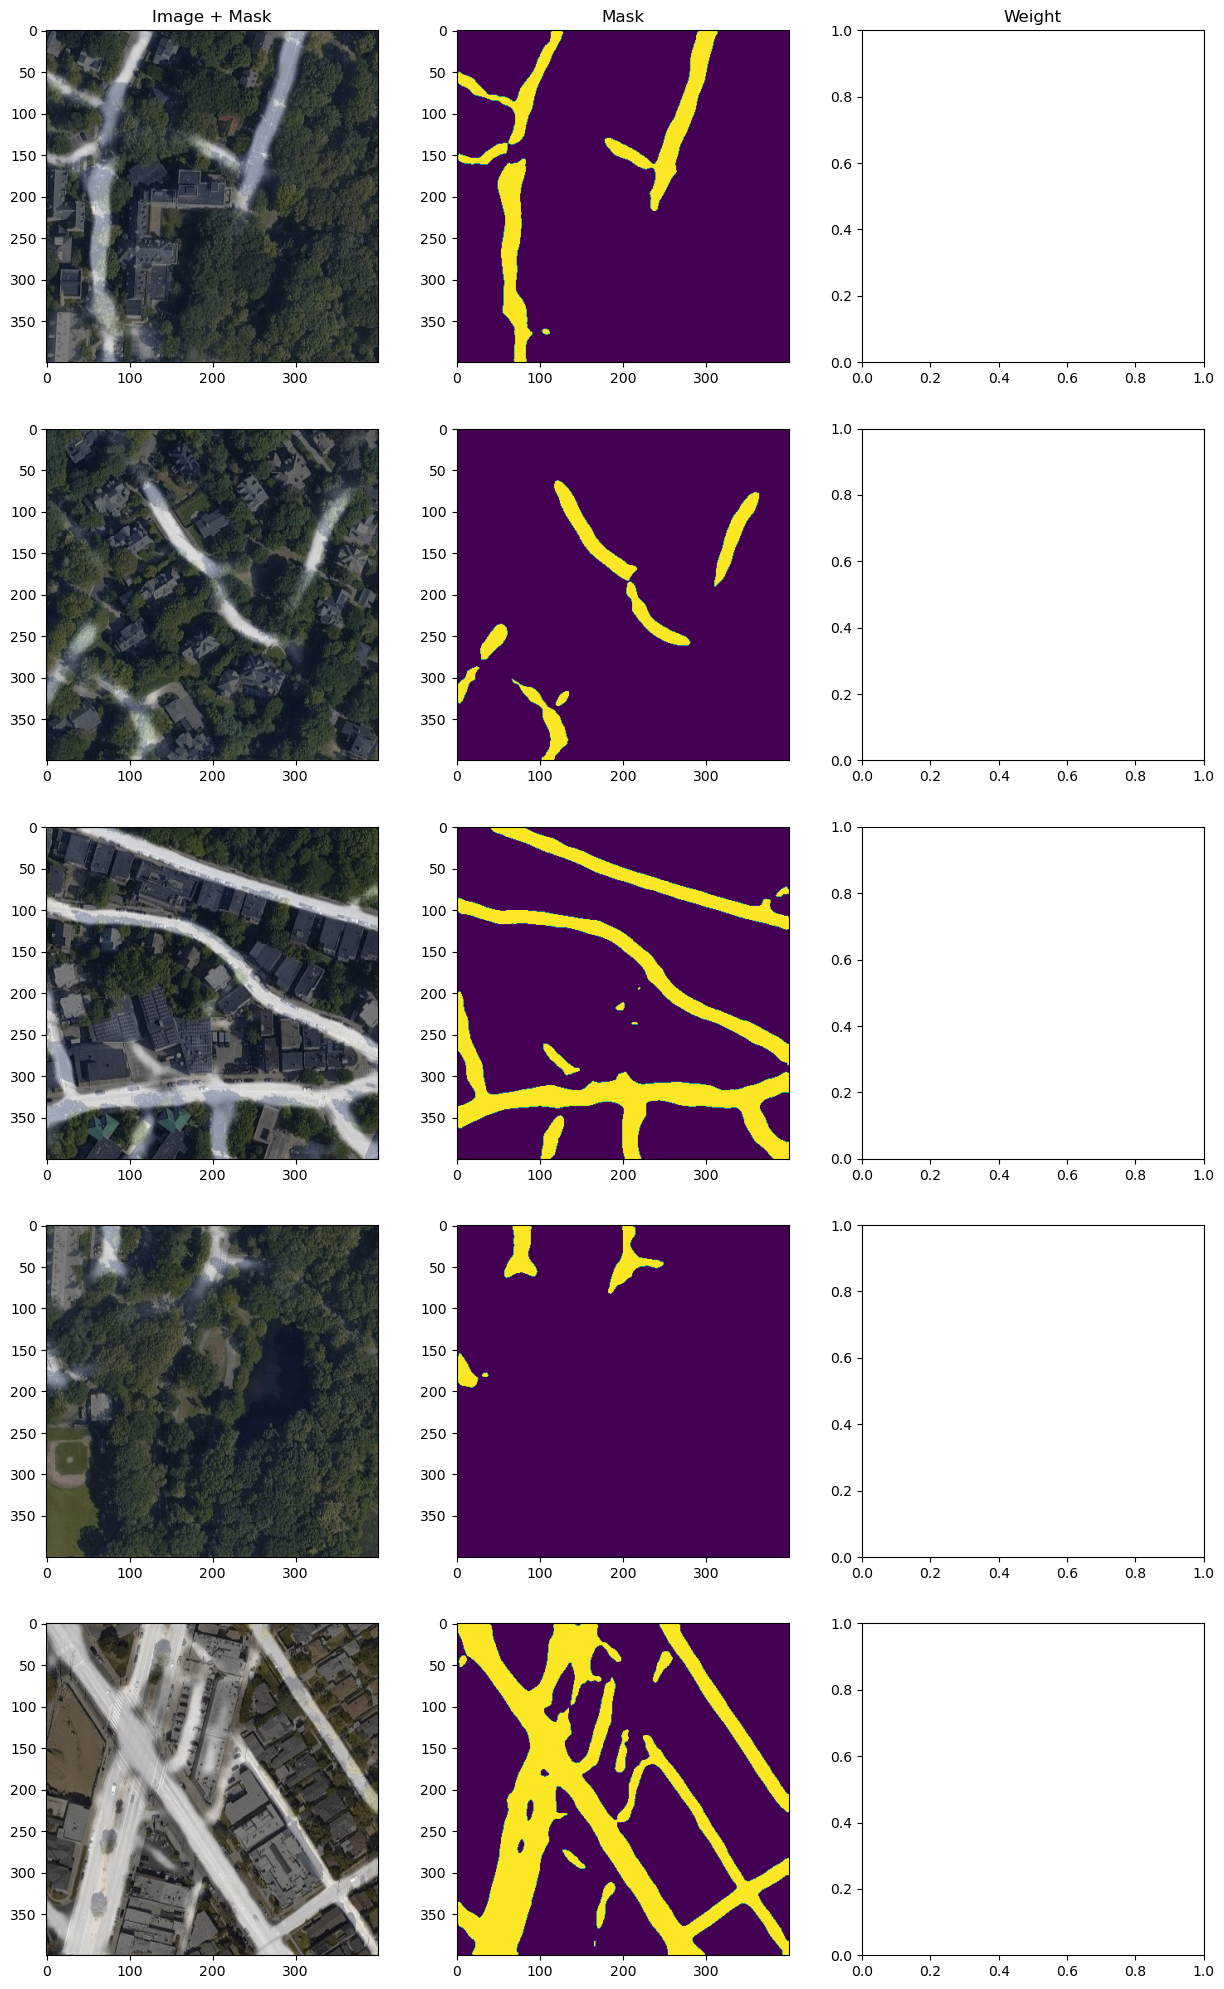

In [25]:
N = 5

images = [torch.tensor(load_image(fname)) for fname in fnames[:N]]
masks = [torch.zeros_like(image) for image in predictions[:N]]
weights = [torch.zeros_like(image) for image in predictions[:N]]

images = torch.stack(images)
masks = torch.stack(masks)
weights = torch.stack(weights)

plot_predictions(
    images=images,
    masks=masks,
    predictions=predictions[:N],
    # weights=predictions[:N] > .5,
)

# Save masks

In [26]:
pred_path = "../data/preds/"

for fname, prediction in tqdm(zip(fnames, predictions), total=len(fnames), ncols=80):
    out_fname = os.path.join(pred_path, os.path.basename(fname))
    prediction = prediction.numpy() > 0.5
    prediction = prediction.astype(np.uint8) * 255
    prediction = np.stack([prediction, prediction, prediction], axis=-1)
    save_mask(prediction, out_fname)

100%|████████████████████████████████████████| 144/144 [00:00<00:00, 380.36it/s]


# Create submission file

In [27]:
fnames = os.listdir(pred_path)
fnames = [os.path.join(pred_path, fname) for fname in fnames if fname.endswith(".png")]

In [28]:
masks_to_submission(
    "../data/submission.csv",
    "",
    *sorted(fnames),
)

# Expected grade

In [29]:
our_score = 0.91308

max_score = 0.94186
baseline_score = 0.86380

4 + 2 * (our_score - baseline_score) / (max_score - baseline_score)

5.262618498590827